Импорт необходимых модулей

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.interpolate import CubicSpline
from scipy.interpolate import Akima1DInterpolator
from scipy.interpolate import PchipInterpolator
from scipy.interpolate import RegularGridInterpolator

import pandas as pd
import json
import sys
sys.path.append('../')
import neftpy.upvt_gas as pvtg
import neftpy.upvt_np_vect as pvtv
import scipy.optimize as opt

Водопьян А.О. Хабибуллин Р.А. 2019 г. 

# Z - фактор, коэффициент сверхсжимаемости для углеводородных газов
 Коэффициент сверхсжимаемости  определяется как

$$ Z=\frac{p V}{n R T}$$
 
где $p$ — давление газа, $T$ — температура, $V$ — молярный объём, $n$ - количество молей.

Для идеального газа коэффициент сжимаемости $Z$ равен единице, и тогда получаем привычное уравнение состояния идеального газа:

$$pV = nRT$$

Для идеального газа коэффициент сжимаемости по определению равен $Z=1$. Во многих реальных приложениях требования к точности требуют учета отклонений от поведения идеального газа, т.е. поведения реального газа. Значение Z обычно увеличивается с ростом давления и уменьшается с ростом температуры. При высоких давлениях молекулы сталкиваются чаще. Это позволяет силам отталкивания между молекулами оказывать заметное влияние, делая молярный объем реального газа больше молярного объема соответствующего идеального газа, что приводит к тому, что Z больше единицы.[3] Когда давление ниже, молекулы могут свободно двигаться. В этом случае преобладают силы притяжения, поэтому $Z<1$. Чем ближе газ к критической точке или точке кипения, тем больше 
Z отклоняется от идеального случая.



# Приведенные давление и температура

Свойства различных углеводородных газов схожи между собой и могут быть обобщены с использованием приведенных давлений и температуры ([Закон соответственных состояний - википедия](https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%BA%D0%BE%D0%BD_%D1%81%D0%BE%D0%BE%D1%82%D0%B2%D0%B5%D1%82%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%BE%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B9))

$$P_{r} = \frac{P}{P_c}$$
$$T_{r} = \frac{T}{T_c}$$
где $p_c$ и $T_c$ критические давление и температура соответственно, которые являются функцией плотности газа и возможного наличия неуглеводородных примесей.

Для значений температур близким к критической, приведенная температура близка к единице. В этом случае поведение газа максимально отличается от идеального, что может вызывать сложности при проведении расчетов по корреляционным зависимостям. Полезно проследить когда достигаются эти условия на практике.



In [2]:
gg_list = np.linspace(0.55, 1.2, 10)
crit_list = np.array([pvtg.unf_pseudocritical_Standing_p_MPa_t_K(gg) for gg in gg_list])

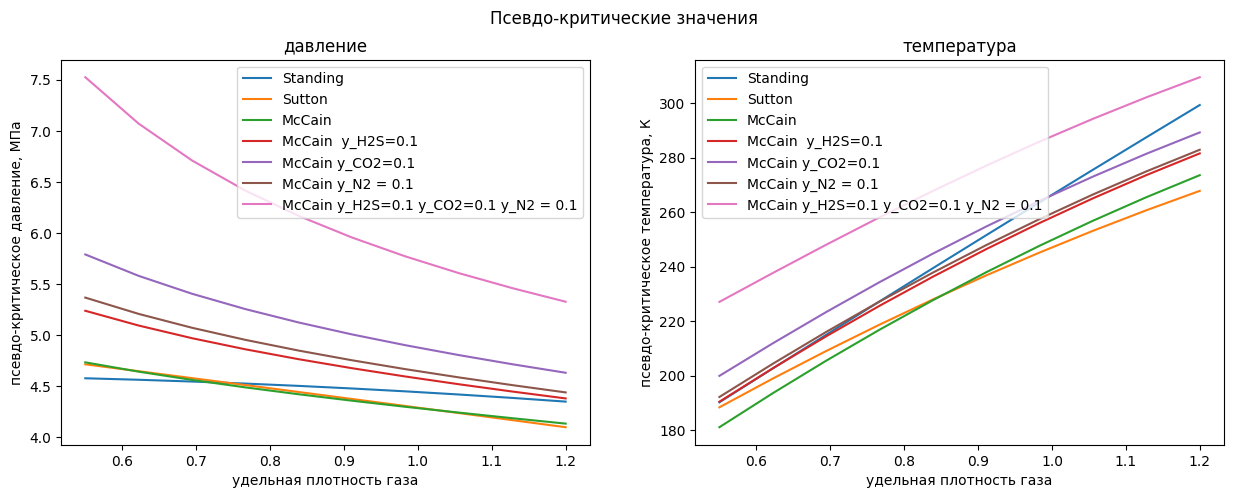

In [3]:
"""
Нарисуем графики псевдо критического давления и температуры от плотности газа

чтобы оценить диапазоны изменения псевдо критических параметров
с учетом наличия примесей
"""
# зададим диапазон изменения удельной плотности газа
gg_list = np.linspace(0.55, 1.2, 10)  # 0.55 плотность метана, вряд ли углеводородный газ будет легче

# рассчитаем критические параметры по корреляции Стендинга 
crit_list = np.array([pvtg.unf_pseudocritical_Standing_p_MPa_t_K(gg) for gg in gg_list])

# рассчитаем критические параметры по корреляции Sutton 
crit_list_2 = np.array([pvtg.unf_pseudocritical_Sutton_p_MPa_t_K(gg) for gg in gg_list])

# зададим значения мольных долей не углеводородных примесей
y_h2s:float=[0, 0.1]
y_co2:float=[0, 0.1]
y_n2:float=[0, 0.1]

# рассчитаем несколько вариантов критических параметров по корреляции МакКейна
crit_list_impurities={}
#t_crit_list_impurities={}
label_impurities={}

crit_list_impurities[1] = np.array([pvtg.unf_pseudocritical_McCain_p_MPa_t_K(gg, y_h2s[0], y_co2[0], y_n2[0]) for gg in gg_list])
label_impurities[1]='McCain'

crit_list_impurities[2] = np.array([pvtg.unf_pseudocritical_McCain_p_MPa_t_K(gg, y_h2s[1], y_co2[0], y_n2[0]) for gg in gg_list])
label_impurities[2]='McCain  y_H2S=0.1'

crit_list_impurities[3] = np.array([pvtg.unf_pseudocritical_McCain_p_MPa_t_K(gg, y_h2s[0], y_co2[1], y_n2[0]) for gg in gg_list])
label_impurities[3]='McCain y_CO2=0.1'

crit_list_impurities[4] = np.array([pvtg.unf_pseudocritical_McCain_p_MPa_t_K(gg, y_h2s[0], y_co2[0], y_n2[1]) for gg in gg_list])
label_impurities[4]='McCain y_N2 = 0.1'

crit_list_impurities[5] = np.array([pvtg.unf_pseudocritical_McCain_p_MPa_t_K(gg, y_h2s[1], y_co2[1], y_n2[1]) for gg in gg_list])
label_impurities[5]='McCain y_H2S=0.1 y_CO2=0.1 y_N2 = 0.1'

# подготовим графики
fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Псевдо-критические значения')
ax[0].plot(gg_list, crit_list[:,0], label = 'Standing' )
ax[1].plot(gg_list, crit_list[:,1], label = 'Standing')
ax[0].plot(gg_list, crit_list_2[:,0], label = 'Sutton' )
ax[1].plot(gg_list, crit_list_2[:,1], label = 'Sutton')
for k in crit_list_impurities.keys():
    ax[0].plot(gg_list, crit_list_impurities[k][:,0], label=label_impurities[k] )
    ax[1].plot(gg_list, crit_list_impurities[k][:,1], label=label_impurities[k] )
ax[0].set(xlabel='удельная плотность газа', ylabel='псевдо-критическое давление, МПа')
ax[0].set_title('давление')
ax[0].legend()

ax[1].set(xlabel='удельная плотность газа', ylabel='псевдо-критическое температура, К')
ax[1].set_title('температура')
ax[1].legend()
plt.show()

Из графиков псевдо-критического давления и температуры видно, что критическое давление лежит в диапазоне от 40 до 50 бар, при наличии примесей в газе может значительно повышаться. При этом критическая температура лежит заметно ниже 273 К (0 С) для газов с плотностью менее 1 ($\gamma_{gas}<1$). Наличие примесей повышает критическую температуру, увеличение плотности также повышает критическую температуру.


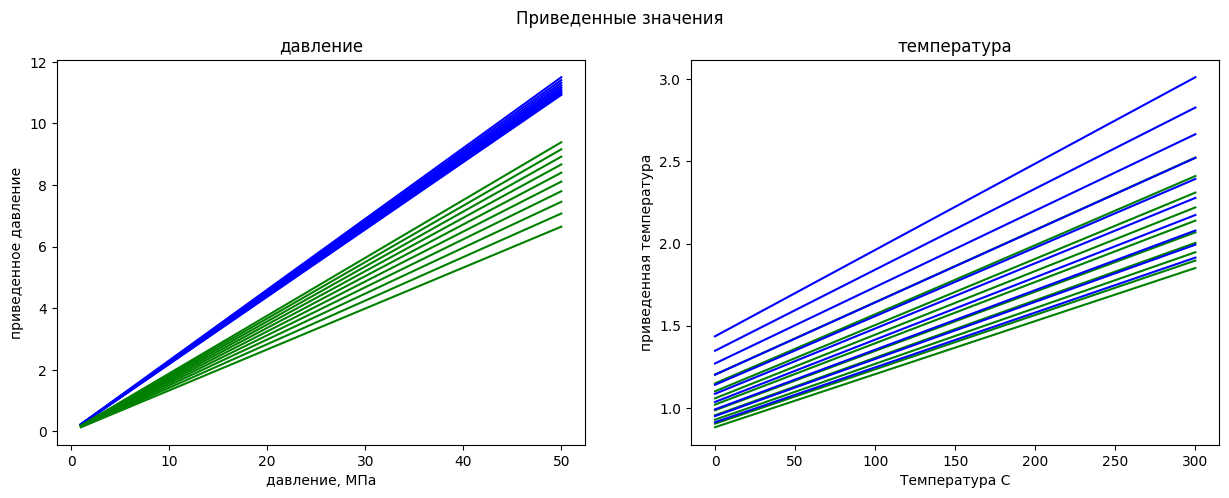

In [4]:
t_list_C = np.linspace(0, 300, 50)
t_list_K = t_list_C + 273
p_list_MPa = np.linspace(1,50, 50)

# нарисуем графики от давления

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Приведенные значения')
y_h2s:float=0.1
y_co2:float=0.1
y_n2:float=0.1

for gg in gg_list:
    (p_crit_Mpa, t_crit_K) = pvtg.unf_pseudocritical_Standing_p_MPa_t_K(gg)
    crit_list_impurities = np.array(pvtg.unf_pseudocritical_McCain_p_MPa_t_K(gg, y_h2s, y_co2, y_n2))
   
    ax[0].plot(p_list_MPa, p_list_MPa/p_crit_Mpa, color='blue')
    ax[0].plot(p_list_MPa, p_list_MPa/crit_list_impurities[0], color='green')

    ax[1].plot(t_list_K-273, t_list_K/t_crit_K, color='blue')
    ax[1].plot(t_list_K-273, t_list_K/crit_list_impurities[1], color='green')

ax[0].set(xlabel='давление, МПа', ylabel='приведенное давление')
ax[0].set_title('давление')
ax[1].set(xlabel='Температура С', ylabel='приведенная температура')
ax[1].set_title('температура')

#ax[1].legend()
plt.show()

из графиков видо, что имеющие практический интерес значения приведенных давления и температуры лежат в диапазонах 
- по давлению от 0 до 12 МПа
- по температуре от 0.8 до 3

При этом надо отметить, что для приведенных температур около единицы могут быть сложности с расчетами по корреляциям. Реальный диапазон приведенных температур где расчет устойчив для большинства методов от 1.05 до 3. Расчеты в зоне критических температур (тяжелые газа, тяжелее воздуха или газы с большим количеством примесей) следует проводить с осторожностью.

# Графики Стендинга Катца

При проведении расчетов часто ориентируются для графики Стендинга Катца, полученные как обобщение экспериментальных данных для углеводородных газов.
[график Стендинга Катца на википедии](https://petrowiki.spe.org/File:Vol1_Page_225_Image_0001.png)
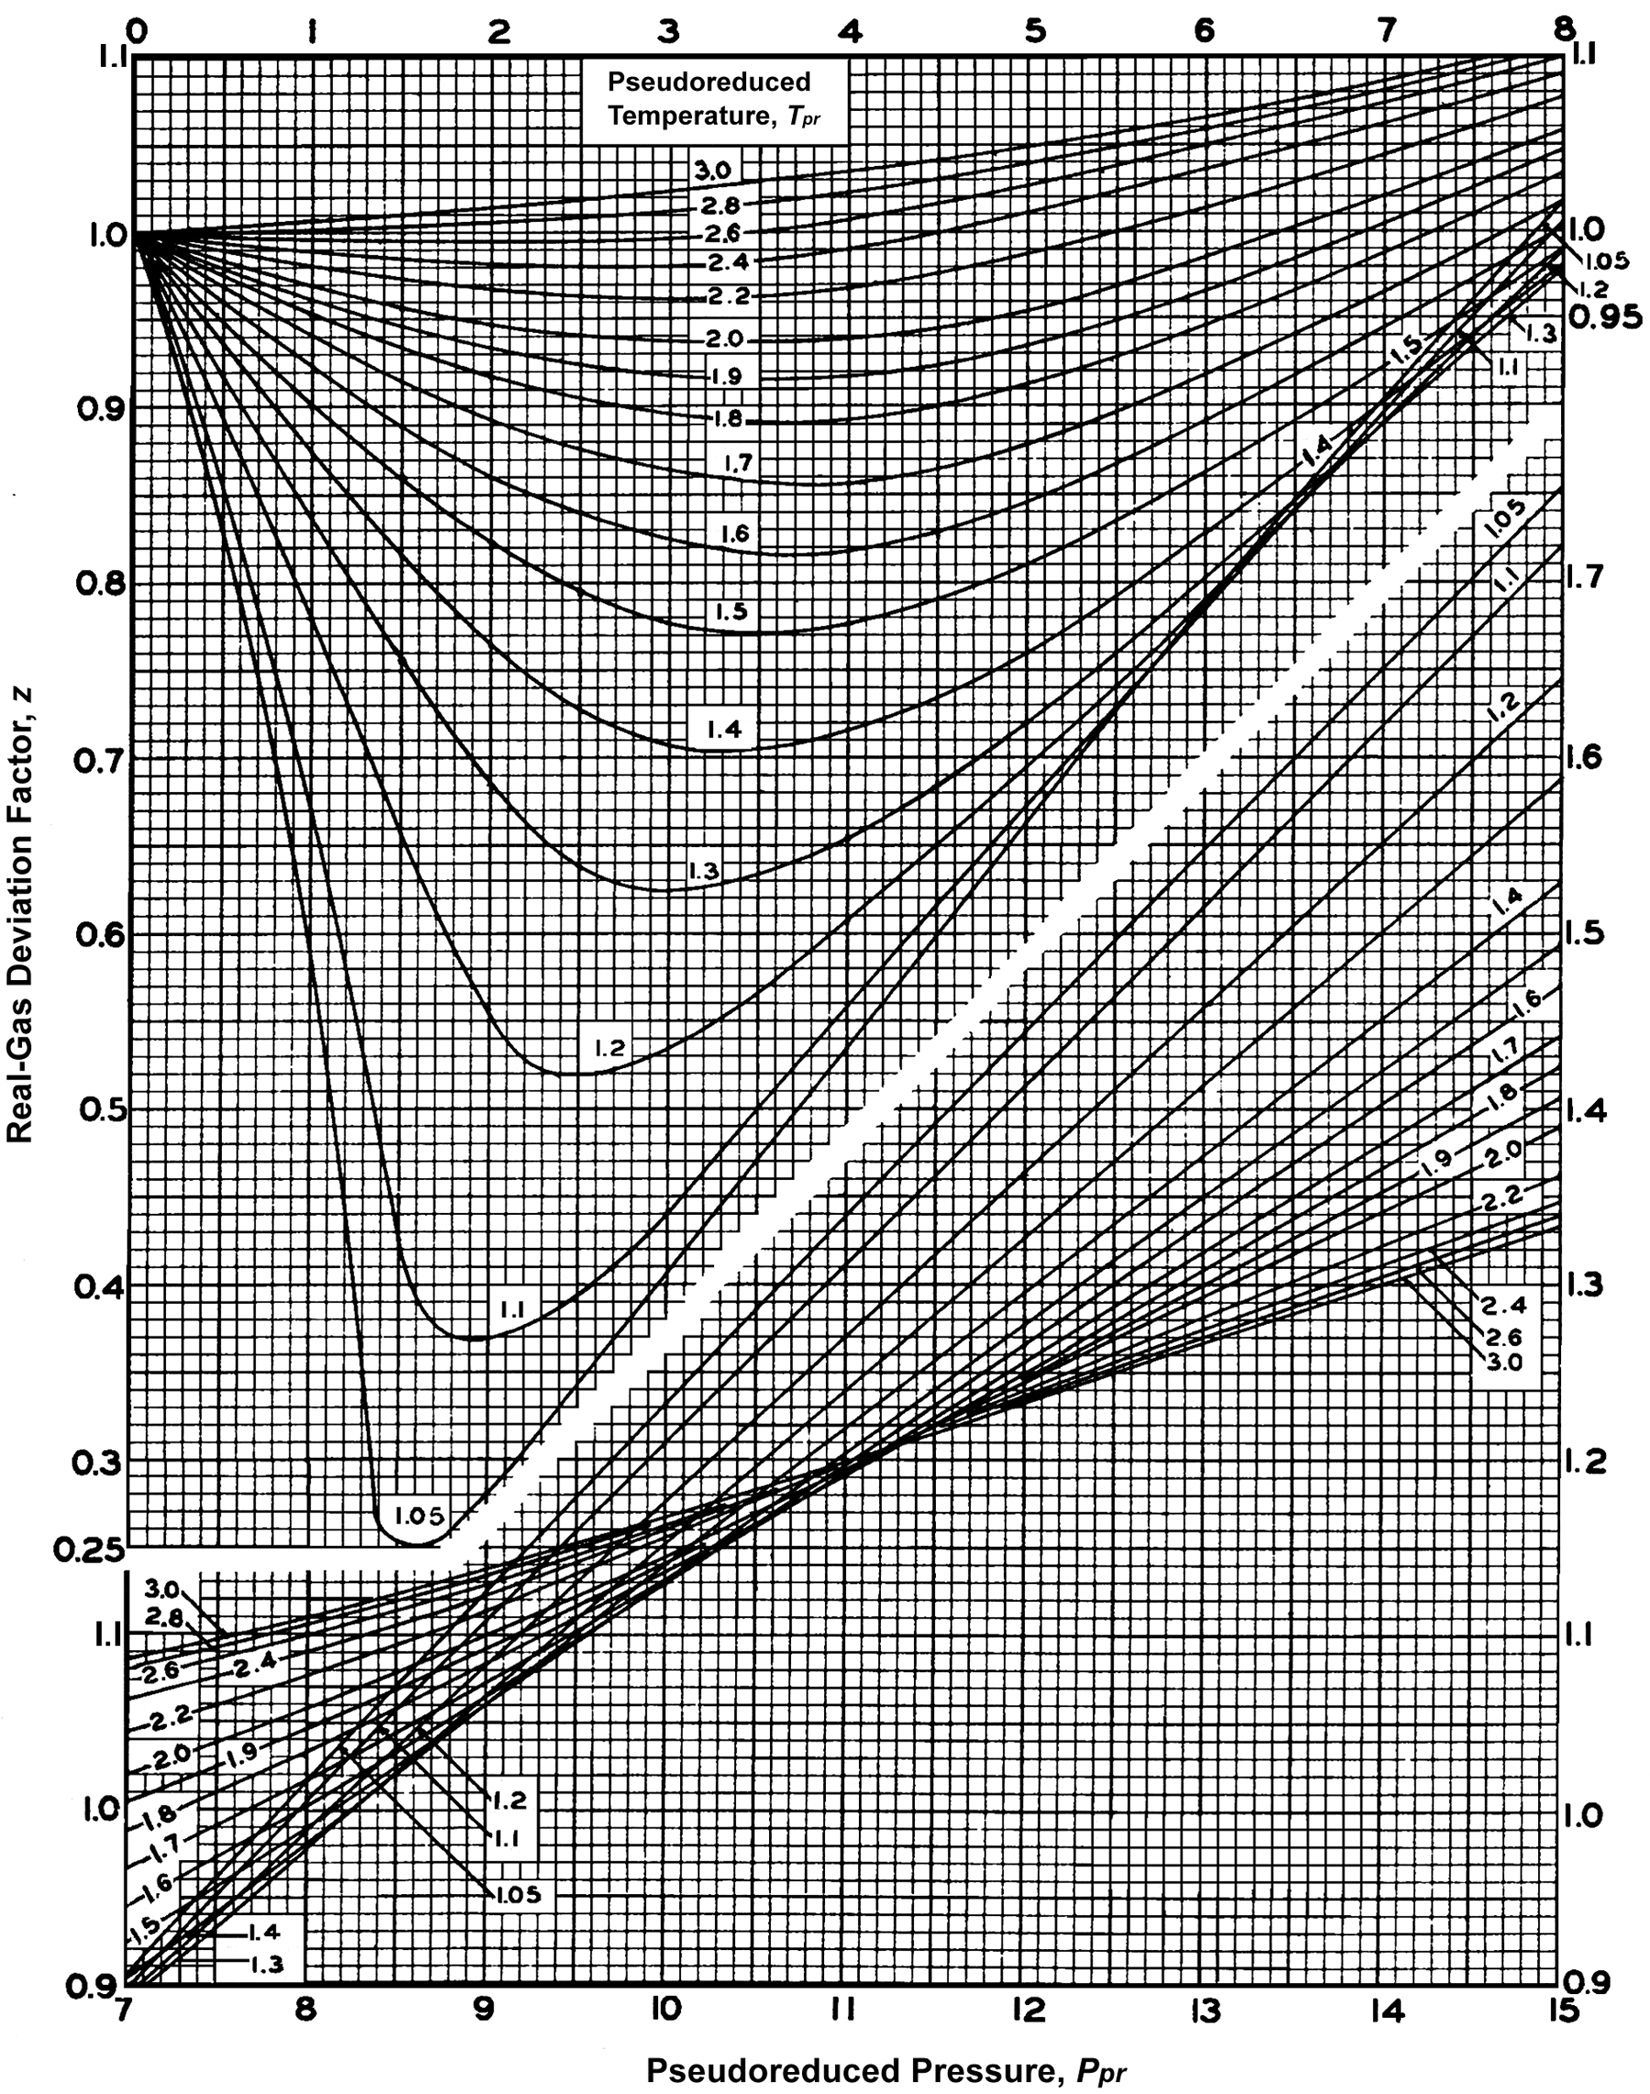

Многие корреляции пытаются созданы на основе этих графиков.

Полезно иметь возможность работать с оцифрованной версией графиков Стендинга Катца


In [5]:
def load_StandingKatz_curve():
    """
    загружает табулированные значения кривых с графика Standing Katz из набора файлов в папке data
    возвращает DataFrame загруженных данных и функцию линейной интерполяции по загруженным данным
    """
    Standing_Katz_Chart_Data = '''
    {
"1.05":{
      "ppr": [0.0, 0.204, 0.3, 0.405, 0.504, 0.602, 0.7, 1.0, 1.203, 1.301, 1.332, 1.351, 1.357, 1.363, 1.37, 1.372, 1.373, 
              1.378, 1.386, 1.397, 1.441, 1.5, 1.601, 1.7, 1.753, 1.801, 1.849, 1.9, 1.951, 2.0, 2.102, 2.503, 3.005, 3.509, 
              4.007, 4.507, 5.007, 5.207, 5.307, 5.505, 5.703, 6.004, 6.507, 7.002, 7.104, 7.201, 7.303, 7.402, 7.506, 7.604, 
              7.802, 7.941, 8.0, 8.1, 8.202, 8.4, 8.537, 8.7, 9.001, 9.505, 10.003, 12.404, 15.0], 
      "z": [1.0, 0.937, 0.905, 0.866, 0.829, 0.79, 0.748, 0.589, 0.44, 0.35, 0.319, 0.3, 0.29, 0.285, 0.279, 0.274, 0.27, 
            0.267, 0.264, 0.262, 0.257, 0.253, 0.251, 0.252, 0.255, 0.26, 0.265, 0.27, 0.275, 0.28, 0.291, 0.343, 0.407, 
            0.471, 0.534, 0.598, 0.663, 0.688, 0.701, 0.727, 0.75, 0.786, 0.846, 0.904, 0.916, 0.928, 0.939, 0.95, 0.962, 
            0.973, 0.995, 1.011, 1.018, 1.028, 1.039, 1.06, 1.074, 1.092, 1.125, 1.178, 1.231, 1.483, 1.751], 
      "tpr": 1.05
      }, 
"1.1": {
      "ppr": [0.0, 0.225, 0.253, 0.279, 0.321, 0.349, 0.378, 0.415, 0.444, 0.456, 0.504, 0.539, 0.567, 0.628, 0.651, 0.676, 
              0.735, 0.757, 0.833, 0.843, 0.863, 0.939, 0.968, 1.004, 1.044, 1.067, 1.081, 1.129, 1.151, 1.169, 1.231, 1.251, 
              1.273, 1.3, 1.327, 1.357, 1.37, 1.403, 1.428, 1.447, 1.467, 1.5, 1.527, 1.55, 1.583, 1.601, 1.63, 1.655, 1.7, 1.744, 
              1.8, 1.85, 1.902, 1.953, 2.004, 2.102, 2.204, 2.301, 2.403, 2.5, 2.605, 2.656, 2.753, 2.855, 2.952, 3.001, 3.054, 
              3.141, 3.206, 3.305, 3.404, 3.504, 3.607, 4.005, 4.505, 5.006, 5.506, 6.004, 6.507, 6.904, 7.002, 7.206, 7.303, 7.403, 
              7.507, 7.801, 8.0, 8.301, 10.001, 11.008, 13.301, 14.802, 15.0], 
      "z": [1.0, 0.942, 0.933, 0.926, 0.912, 0.903, 0.895, 0.882, 0.874, 0.869, 0.854, 0.842, 0.832, 0.811, 0.802, 0.793, 0.772, 
            0.764, 0.736, 0.733, 0.724, 0.694, 0.684, 0.669, 0.654, 0.643, 0.637, 0.615, 0.604, 0.594, 0.565, 0.554, 0.544, 0.53, 
            0.516, 0.503, 0.494, 0.476, 0.463, 0.454, 0.444, 0.426, 0.412, 0.405, 0.396, 0.393, 0.386, 0.382, 0.377, 0.373, 0.37, 
            0.369, 0.368, 0.368, 0.369, 0.372, 0.376, 0.38, 0.387, 0.393, 0.401, 0.405, 0.414, 0.424, 0.434, 0.44, 0.445, 0.456, 
            0.464, 0.476, 0.487, 0.5, 0.511, 0.557, 0.615, 0.673, 0.729, 0.784, 0.841, 0.886, 0.897, 0.92, 0.931, 0.942, 0.952,   
            0.985, 1.006, 1.037, 1.209, 1.31, 1.543, 1.697, 1.717], 
      "tpr": 1.1
      }, 
"1.2": {
      "ppr": [0.0, 0.2, 0.3, 0.4, 0.504, 0.547, 0.634, 0.755, 0.847, 1.0, 1.146, 1.267, 1.351, 1.435, 1.503, 1.549, 1.643, 1.734, 
              1.837, 1.943, 2.0, 2.052, 2.103, 2.201, 2.25, 2.302, 2.501, 2.593, 2.657, 2.75, 2.833, 3.005, 3.203, 3.507, 3.705, 
              3.802, 3.905, 4.005, 4.106, 4.203, 4.342, 4.505, 4.658, 4.872, 5.007, 5.128, 5.239, 5.357, 5.509, 5.659, 5.758, 5.854, 
              6.001, 6.507, 7.004, 7.1, 7.289, 7.355, 7.5, 7.901, 8.001, 8.602, 10.305, 10.605, 11.91, 13.502, 14.603, 14.903, 15.0], 
      "z": [1.0, 0.958, 0.938, 0.916, 0.893, 0.883, 0.864, 0.836, 0.815, 0.779, 0.744, 0.715, 0.695, 0.674, 0.657, 0.646, 0.625, 
            0.605, 0.584, 0.565, 0.554, 0.545, 0.538, 0.528, 0.524, 0.522, 0.519, 0.519, 0.52, 0.523, 0.526, 0.534, 0.545, 0.565, 
            0.581, 0.589, 0.599, 0.607, 0.616, 0.624, 0.636, 0.65, 0.663, 0.683, 0.695, 0.706, 0.716, 0.726, 0.741, 0.755, 0.765, 
            0.774, 0.789, 0.841, 0.891, 0.901, 0.922, 0.926, 0.941, 0.98, 0.99, 1.045, 1.203, 1.231, 1.352, 1.501, 1.605, 1.633, 1.642], 
      "tpr": 1.2
       }, 
"1.3": {
      "ppr": [0.0, 0.201, 0.302, 0.401, 0.504, 0.6, 0.804, 1.002, 1.202, 1.303, 1.503, 1.802, 2.009, 2.203, 2.504, 2.704, 3.008, 
              3.204, 3.509, 3.808, 4.001, 4.308, 4.509, 4.809, 5.009, 5.308, 5.506, 5.806, 6.004, 6.207, 6.307, 6.503, 7.005, 7.29, 
              7.309, 7.504, 7.906, 8.001, 10.361, 10.707, 14.803, 15.0], 
      "z": [1.0, 0.967, 0.95, 0.935, 0.916, 0.901, 0.868, 0.835, 0.804, 0.788, 0.756, 0.713, 0.684, 0.663, 0.638, 0.629, 0.624, 
            0.626, 0.633, 0.645, 0.653, 0.671, 0.684, 0.705, 0.719, 0.743, 0.759, 0.786, 0.802, 0.82, 0.829, 0.844, 0.892, 0.917, 
            0.916, 0.934, 0.969, 0.979, 1.182, 1.212, 1.567, 1.585], 
      "tpr": 1.3
       }, 
"1.4": {
      "ppr": [0.0, 0.267, 0.344, 0.503, 0.744, 1.001, 1.402, 1.502, 1.905, 2.003, 2.132, 2.243, 2.358, 2.503, 2.607, 2.746, 2.84, 
              2.957, 3.005, 3.062, 3.103, 3.203, 3.304, 3.404, 3.506, 3.611, 3.707, 3.807, 3.905, 4.006, 4.258, 4.344, 4.507, 4.754, 
              5.007, 5.262, 5.408, 5.507, 6.005, 6.507, 6.748, 6.804, 7.002, 7.302, 7.356, 7.503, 7.836, 7.903, 8.002, 12.907, 13.805, 
              14.304, 14.504, 15.0], 
      "z": [1.0, 0.965, 0.955, 0.936, 0.906, 0.874, 0.827, 0.816, 0.774, 0.764, 0.753, 0.744, 0.736, 0.727, 0.722, 0.715, 0.712, 
            0.708, 0.707, 0.705, 0.705, 0.704, 0.704, 0.704, 0.705, 0.706, 0.708, 0.71, 0.713, 0.716, 0.724, 0.727, 0.734, 0.746, 
            0.76, 0.775, 0.785, 0.792, 0.828, 0.865, 0.884, 0.888, 0.903, 0.928, 0.931, 0.942, 0.968, 0.974, 0.981, 1.364, 1.433, 
            1.472, 1.487, 1.526], 
      "tpr": 1.4
       }, 
"1.5": {
      "ppr": [0.0, 0.202, 0.303, 0.404, 0.506, 0.701, 0.801, 1.0, 1.304, 1.505, 1.803, 2.006, 2.103, 2.504, 2.705, 3.006, 3.104, 
            3.509, 3.806, 4.006, 4.209, 4.505, 4.604, 5.008, 5.307, 5.508, 5.806, 6.005, 6.307, 6.502, 6.703, 7.003, 7.305, 7.506, 
            7.707, 7.804, 7.904, 8.001, 12.808, 13.207, 13.907, 14.304, 14.903, 15.0], 
      "z": [1.0, 0.978, 0.967, 0.958, 0.948, 0.929, 0.919, 0.9, 0.875, 0.859, 0.836, 0.822, 0.816, 0.794, 0.786, 0.776, 0.774, 0.77, 
            0.773, 0.777, 0.781, 0.79, 0.794, 0.81, 0.825, 0.836, 0.851, 0.863, 0.88, 0.892, 0.904, 0.924, 0.943, 0.956, 0.97, 0.977, 
            0.984, 0.99, 1.334, 1.362, 1.412, 1.441, 1.485, 1.492], 
      "tpr": 1.5
       }, 
"1.6": {
      "ppr": [0.0, 0.226, 0.502, 1.0, 1.505, 1.704, 2.0, 2.303, 2.502, 2.606, 2.707, 3.006, 3.204, 3.407, 3.506, 3.708, 3.807, 
            4.006, 4.207, 4.508, 4.706, 4.809, 5.006, 5.211, 5.309, 5.503, 5.707, 6.005, 6.506, 7.0, 7.504, 7.6, 8.0, 15.0], 
      "z": [1.0, 0.981, 0.959, 0.923, 0.888, 0.876, 0.86, 0.847, 0.839, 0.835, 0.832, 0.824, 0.82, 0.817, 0.816, 0.815, 0.815,
             0.818, 0.821, 0.829, 0.835, 0.838, 0.846, 0.854, 0.858, 0.868, 0.877, 0.892, 0.918, 0.946, 0.974, 0.979, 1.002, 1.46],
      "tpr": 1.6
       }, 
"1.7": {
      "ppr": [0.0, 0.198, 0.297, 0.396, 0.497, 0.694, 0.795, 0.996, 1.096, 1.303, 1.497, 1.696, 1.899, 2.0, 2.196, 2.501, 2.6, 
            2.902, 3.004, 3.196, 3.502, 3.604, 3.804, 4.0, 4.101, 4.302, 4.504, 4.596, 5.002, 5.203, 5.502, 5.701, 6.005, 6.201, 
            6.5, 6.799, 7.003, 7.201, 7.4, 7.598, 8.0, 14.801, 15.0], 
      "z": [1.0, 0.986, 0.979, 0.974, 0.968, 0.957, 0.951, 0.941, 0.935, 0.924, 0.914, 0.905, 0.896, 0.892, 0.885, 0.876, 0.873, 
            0.866, 0.863, 0.861, 0.857, 0.856, 0.855, 0.856, 0.857, 0.86, 0.864, 0.868, 0.879, 0.886, 0.897, 0.905, 0.918, 0.928, 
            0.942, 0.956, 0.966, 0.975, 0.985, 0.996, 1.018, 1.427, 1.439], 
      "tpr": 1.7}, 
"1.8": {
      "ppr": [0.0, 0.504, 1.003, 1.501, 2.0, 2.505, 3.003, 3.507, 4.005, 4.503, 5.006, 5.504, 6.002, 6.505, 7.003, 7.5, 8.003, 15.0], 
      "z": [1.0, 0.974, 0.952, 0.933, 0.917, 0.905, 0.896, 0.891, 0.893, 0.901, 0.913, 0.929, 0.947, 0.967, 0.988, 1.01, 1.034, 1.42], 
      "tpr": 1.8
       }, 
"1.9": {
      "ppr": [0.0, 0.503, 1.003, 1.507, 2.005, 2.504, 3.008, 3.506, 4.004, 4.502, 5.006, 5.504, 6.007, 6.505, 7.002, 7.505, 8.002, 15.0], 
      "z": [1.0, 0.978, 0.96, 0.945, 0.933, 0.924, 0.917, 0.916, 0.917, 0.924, 0.935, 0.949, 0.966, 0.985, 1.005, 1.026, 1.047, 1.406], 
      "tpr": 1.9
       }, 
"2": {
      "ppr": [0.0, 0.3, 0.403, 0.505, 0.702, 0.801, 1.002, 1.2, 1.501, 1.602, 1.805, 2.001, 2.104, 2.205, 2.504, 2.903, 3.006, 3.108, 
            3.506, 3.605, 3.806, 4.01, 4.405, 4.506, 4.605, 5.009, 5.106, 5.408, 5.505, 5.708, 6.008, 6.305, 6.504, 6.802, 7.004, 
            7.205, 7.505, 7.701, 8.005, 8.203, 13.006, 14.309, 15.0], 
      "z": [1.0, 0.989, 0.985, 0.982, 0.977, 0.974, 0.969, 0.963, 0.956, 0.954, 0.95, 0.947, 0.945, 0.944, 0.941, 0.937, 0.937, 0.937, 
            0.937, 0.937, 0.938, 0.939, 0.944, 0.945, 0.947, 0.955, 0.957, 0.966, 0.969, 0.976, 0.986, 0.996, 1.003, 1.014, 1.021, 
            1.028, 1.039, 1.046, 1.059, 1.066, 1.291, 1.354, 1.388], 
      "tpr": 2
       }, 
"2.2": {
      "ppr": [0.0, 0.502, 1.0, 1.503, 2.003, 2.501, 3.002, 3.104, 3.2, 3.3, 3.503, 3.803, 4.006, 4.505, 5.006, 5.504, 6.003, 6.505, 
            7.002, 7.506, 7.602, 8.001, 8.2, 8.755, 13.006, 14.006, 14.907, 15.0], 
      "z": [1.0, 0.989, 0.98, 0.973, 0.967, 0.963, 0.961, 0.961, 0.961, 0.962, 0.963, 0.965, 0.968, 0.976, 0.987, 1.0, 1.014, 1.029, 
            1.044, 1.06, 1.064, 1.077, 1.083, 1.103, 1.28, 1.32, 1.356, 1.36], 
      "tpr": 2.2
       }, 
"2.4": {
      "ppr": [0.0, 0.402, 0.504, 0.602, 1.0, 1.201, 1.401, 1.502, 1.704, 1.9, 2.004, 2.504, 3.008, 3.102, 3.506, 3.601, 3.705, 3.808, 
            4.006, 4.306, 4.504, 4.708, 5.004, 5.207, 5.503, 5.606, 6.001, 6.506, 6.703, 7.004, 7.102, 7.5, 7.801, 7.901, 8.0, 8.502, 
            8.801, 9.102, 9.402, 9.601, 14.208, 15.0], 
      "z": [1.0, 0.994, 0.993, 0.992, 0.988, 0.986, 0.985, 0.984, 0.982, 0.981, 0.981, 0.98, 0.98, 0.981, 0.983, 0.984, 0.986, 0.987, 
            0.99, 0.995, 0.999, 1.004, 1.011, 1.016, 1.023, 1.026, 1.036, 1.049, 1.054, 1.062, 1.065, 1.076, 1.085, 1.087, 1.091, 
            1.105, 1.115, 1.126, 1.137, 1.145, 1.317, 1.346], 
      "tpr": 2.4
       }, 
"2.6": {
      "ppr": [0.0, 0.502, 1.001, 1.5, 2.002, 2.505, 3.004, 3.505, 4.003, 4.504, 5.004, 5.506, 6.003, 6.501, 7.001, 7.4, 7.502, 7.901, 
            14.106, 14.606, 14.905, 15.0], 
      "z": [1.0, 0.997, 0.995, 0.994, 0.994, 0.994, 0.996, 1.0, 1.007, 1.016, 1.026, 1.038, 1.05, 1.062, 1.074, 1.084, 1.086, 1.097, 
            1.306, 1.324, 1.334, 1.338], 
      "tpr": 2.6
       }, 
"2.8": {
      "ppr": [0.0, 0.501, 1.002, 1.253, 1.503, 2.003, 2.501, 3.005, 3.504, 4.005, 4.506, 5.006, 5.506, 6.004, 6.504, 7.004, 7.5, 15.0], 
      "z": [1.0, 0.999, 1.0, 1.001, 1.002, 1.005, 1.008, 1.011, 1.016, 1.022, 1.03, 1.039, 1.049, 1.059, 1.069, 1.081, 1.093, 1.333], 
      "tpr": 2.8
       }, 
"3": {
      "ppr": [0.0, 0.503, 1.0, 1.501, 2.002, 2.502, 3.005, 3.102, 3.504, 4.004, 4.507, 5.005, 5.501, 6.003, 6.504, 7.001, 7.601, 
            7.801, 8.2, 14.102, 14.805, 15.0], 
      "z": [1.0, 1.002, 1.006, 1.009, 1.013, 1.018, 1.023, 1.024, 1.029, 1.034, 1.041, 1.048, 1.056, 1.065, 1.075, 1.086, 1.1, 
            1.104, 1.115, 1.302, 1.325, 1.332], 
      "tpr": 3
       }
}
    '''
    
    #with open(r'data\Standing_Katz_Chart_Data.json', 'r') as fp:
    #    dict_SK = json.load( fp)
    dict_SK = json.loads(Standing_Katz_Chart_Data)
    tpr = list(dict_SK.keys())
    
    df = pd.DataFrame()
    try:
        for k in dict_SK.keys():
            
            ppr = np.array(dict_SK[k]['ppr'])
            z = np.array(dict_SK[k]['z'])
            t = dict_SK[k]['tpr']
            df_SK_t = pd.DataFrame({f"tpr = {t}":z}, index = ppr)
            if df.shape[0]==0:
                df = df_SK_t.copy()
            else:
                df =df.join(df_SK_t, how='outer')
            df = df.sort_index().interpolate(method='index')
        # пробуем сделать интерполятор на регулярной сетке
        ppr = np.array(df.index)
        tpr = np.array(tpr)
        data = np.array(df)
        interp = RegularGridInterpolator((ppr, tpr), data,
                                         bounds_error=False, fill_value=None)
        return {'df':df, 'interp':interp}
    except Exception as e:
        print(e)

# можно получить таблицу данных считанных непосредственно с графика Стендинга Катца
StandingKatz_curve = load_StandingKatz_curve()
df = StandingKatz_curve['df']

<Axes: title={'center': 'График Стендинга Катца оцифрованный'}, xlabel='$p_{pr}$', ylabel='z'>

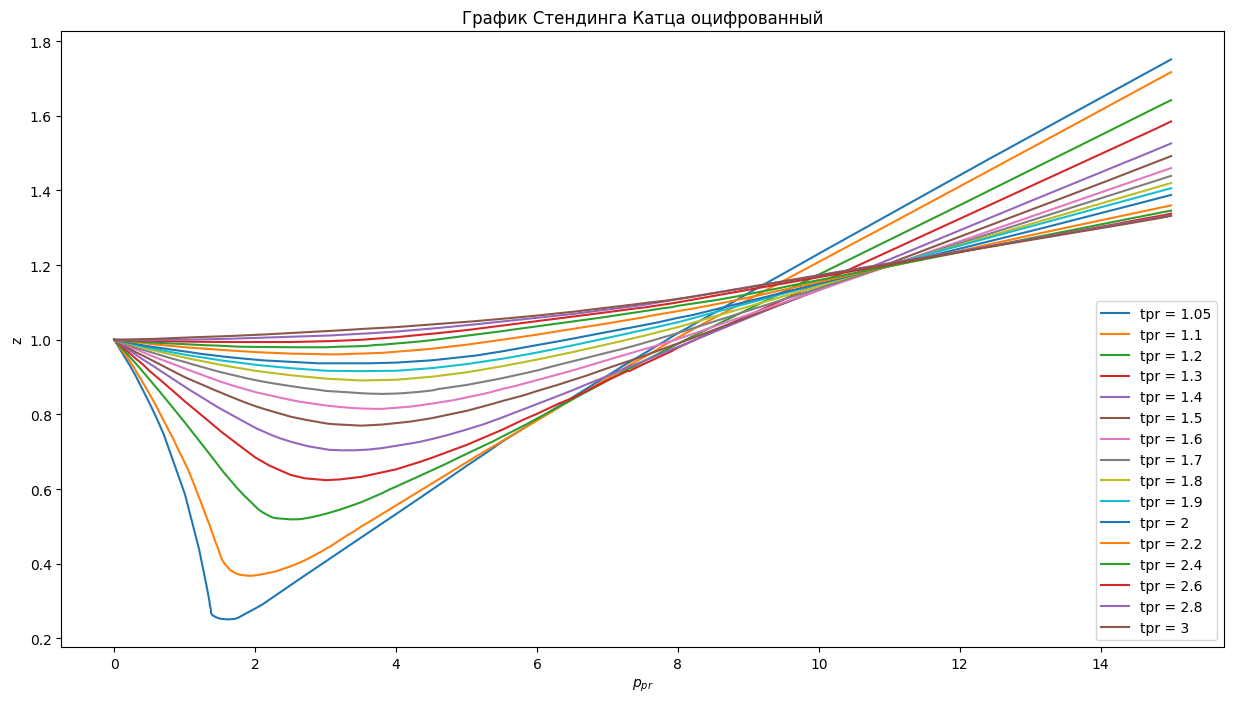

In [6]:

df.plot(figsize=(15,8), title='График Стендинга Катца оцифрованный', xlabel='$p_{pr}$', ylabel='z')

In [7]:
# можно получить функцию интеполирующую (и экстрполирующую) считанную таблицу
interp_SK = StandingKatz_curve['interp']

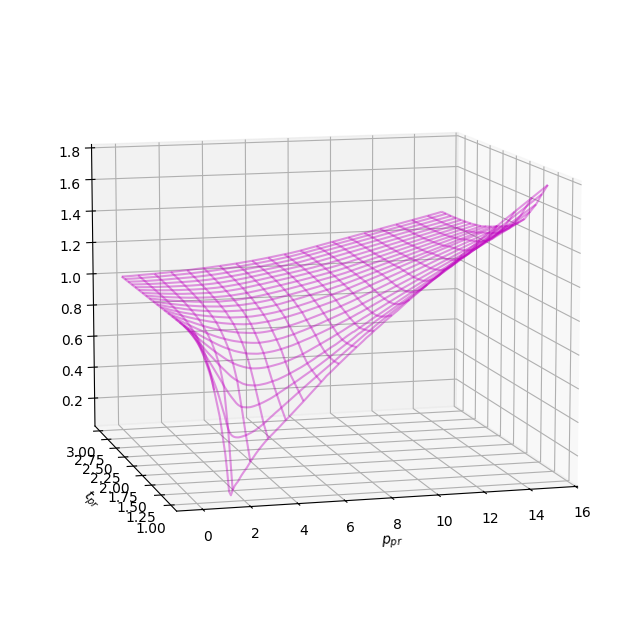

In [8]:
# трехмерное представление считанной таблицы
X, Y = np.meshgrid(np.linspace(0,15,200), 
                   np.linspace(1,3,200), 
                   indexing='ij')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=10, azim=-105, roll=0)
ax.plot_wireframe(X, Y, interp_SK((X,Y)), rstride=10, cstride=10,
                  alpha=0.4, color='m', label='linear interp')
ax.set_xlabel('$p_{pr}$')
ax.set_ylabel('$t_{pr}$')

plt.show()

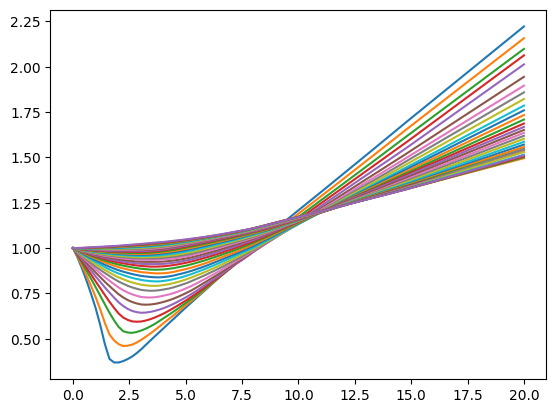

In [9]:
tpr = np.linspace(1.1,3,35)
ppr = np.linspace(0, 20, 100)
for t in tpr:
    plt.plot(ppr, interp_SK((ppr, t)))
plt.show()

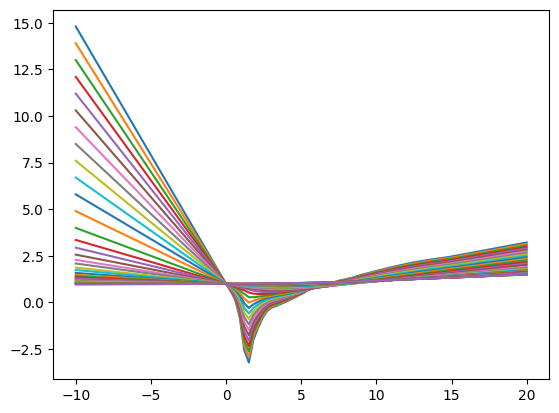

In [10]:
# экстраполяция в область приведенных температур менее 1 и отрицательных давлений может приводить к странным результатам
# исходный диапазон построение данных по графику Стендинга Катца tpr от 1.05 до 3, по ppr от 0 до 15!

tpr = np.linspace(0,3,35)
ppr = np.linspace(-10, 20, 100)
for t in tpr:
    plt.plot(ppr, interp_SK((ppr, t)))
plt.show()

#  DAK  Dranchuk Abu Kassem
Источник: Dranchuk P. M. et al. Calculation of Z factors for natural gases using equations of state //Journal of Canadian Petroleum Technology. – 1975. – Т. 14. – №. 03.

Коэффициент сверхсжимаемости учитывает отклонение свойств реального газа от идеального.

Dranchuk P. M. et al. получили уравнение состояния реального газа адаптировав его к экспериментальным данным Stending and Katz

$$Z = 1 + 
(A_1 +\frac{A_2}{T_r} +\frac{A_3}{T_{r}^3} +\frac{A_4}{T_{r}^4} +\frac{A_5}{T_{r}^5})\rho_{r} + 
(A_6 +\frac{A_7}{T_{r}^2} +\frac{A_8}{T_{r}^8})\rho_{r}^2 - 
A_9(\frac{A_7}{T_{r}} +\frac{A_6}{T_{r}^2})\rho_{r}^5 - 
A_{10} (1 + A_{11} \rho_{r}^2) \frac{\rho_{r}^2}{T_{r}^3}exp(-A_{11}\rho_{r}{2})$$
где:
$$\rho_r = \frac{Z_c P_r}{Z T_r}$$
причем:
$$Z_c = 0.27$$
коэффициенты:
$$A_1 =0.3265$$
$$A_2 =-1.0700$$
$$A_3 =-0.5339$$
$$A_4 =0.01569$$
$$A_5 =-0.05165$$
$$A_6 =0.5475$$
$$A_7 =-0.7361$$
$$A_8 =0.1844$$
$$A_{9} =0.1056$$
$$A_{10} =0.6134$$
$$A_{11} =0.7210$$
а приведенные давление и температура:
$$P_{r} = \frac{P}{P_c}$$
$$T_{r} = \frac{T}{T_c}$$
где $p_c$ и $T_c$ критические давление и температура соответственно

Dranchuk and Abou-Kassem[8] found an average absolute error of 0.486% in their equation, with a standard deviation of 0.00747 over ranges of pseudoreduced pressure and temperature of 0.2 < ppr < 30; 1.0 < Tpr < 3.0; and for ppr < 1.0 with 0.7 < Tpr < 1.0.

Dranchuk and Abou-Kassem[8] also found that this equation and other equations of state give unacceptable results near the critical temperature for Tpr = 1.0 and ppr >1.0, so these equations are not recommended in this range.

In [11]:
# вытащим функцию из модели Дранчука, чтобы поисследовать ее
def f(z, ppr, tpr):
    #z, ropr = variables
    #func = np.zeros(2)
    ropr = 0.27 * (ppr / (z * tpr)) 
    func = -z + 1 + \
            (0.3265 - 1.0700 / tpr - 0.5339 / tpr**3 + 0.01569 / tpr ** 4 - 0.05165 / tpr ** 5) * ropr +\
            (0.5475 - 0.7361 / tpr + 0.1844 / tpr ** 2) * ropr ** 2 - \
            0.1056 * (-0.7361 / tpr + 0.1844 / tpr ** 2) * ropr ** 5 + \
            0.6134 * (1 + 0.7210 * ropr ** 2) * (ropr ** 2 / tpr ** 3) * np.exp(-0.7210 * ropr ** 2)
    #print(z, func)
    return func

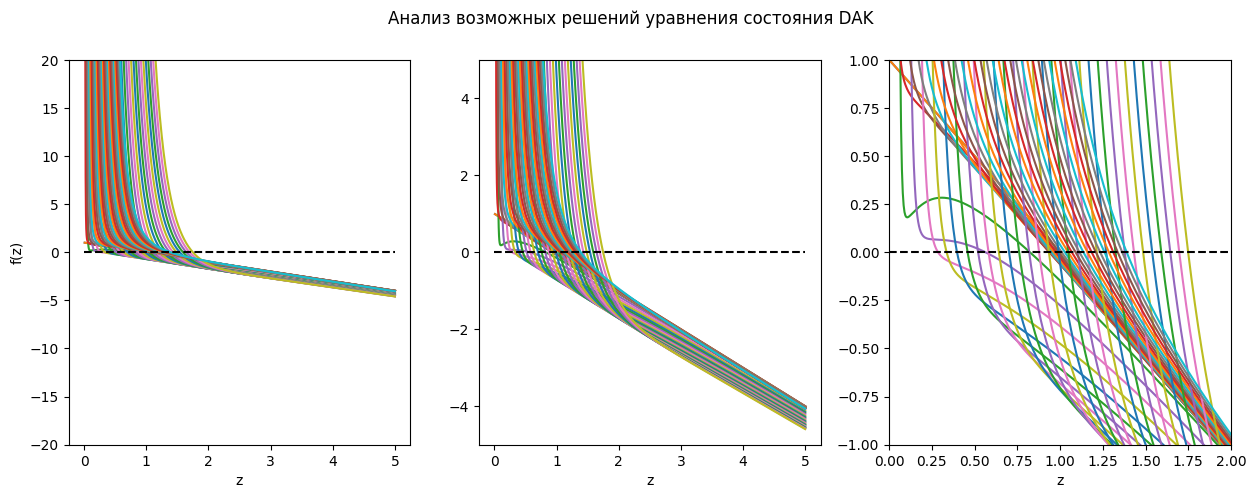

In [12]:
# построим графики функций на основе уравнения состояния из модели DAK

# сначала для диапазона, где все должно хорошо работать
z = np.linspace(0.01, 5, 1000)
ppr_list = np.linspace(0, 15, 30)  
tpr_list = np.linspace(1.05, 2, 2)

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('Анализ возможных решений уравнения состояния DAK')
for ppr in ppr_list:
    for tpr in tpr_list:
        ax[0].plot(z,f(z,ppr,tpr))
        ax[1].plot(z,f(z,ppr,tpr))
        ax[2].plot(z,f(z,ppr,tpr))


ax[0].plot([0,5],[0,0], color='black', linestyle='dashed')
ax[1].plot([0,5],[0,0], color='black', linestyle='dashed')
ax[2].plot([0,5],[0,0], color='black', linestyle='dashed')

ax[0].set_ylim(-20,20)
ax[1].set_ylim(-5,5)
ax[2].set_ylim(-1, 1)
ax[2].set_xlim(0, 2)

ax[0].set(xlabel='z', ylabel='f(z)')
ax[1].set(xlabel='z')
ax[2].set(xlabel='z')
plt.show()

В диапазоне ppr от 0 до 15 и tpr от 1.05 до 3 решение существует, единственно и может быть найдено, например, методом деления отрезка попалам. 

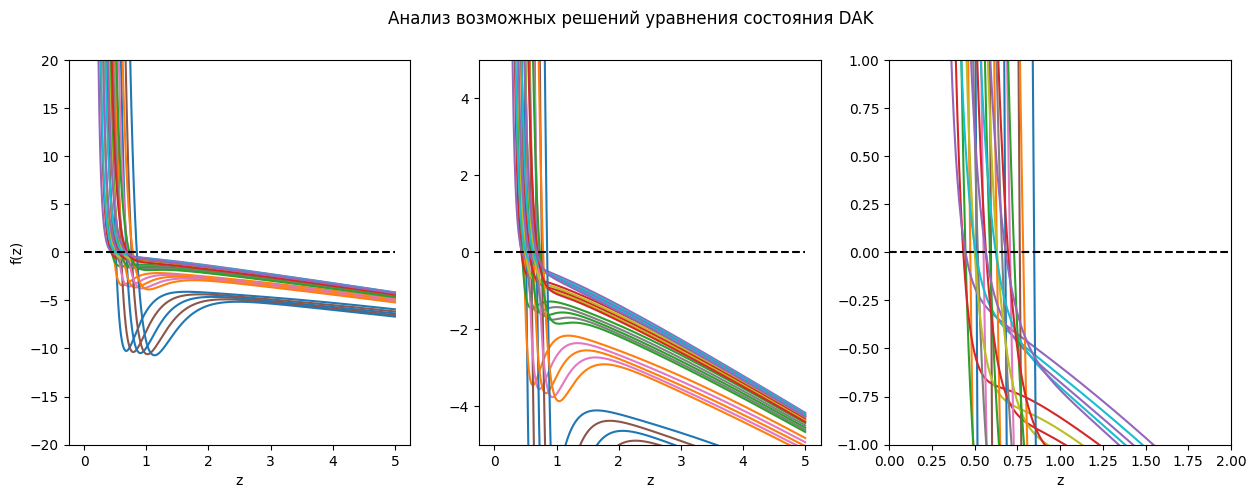

In [13]:
# построим графики функций на основе уравнения состояния из модели DAK

# потом для диапазона, где все должно хорошо работать, но может отличаться от реальности
z = np.linspace(0.01, 5, 1000)
ppr_list = np.linspace(3, 5, 5)  
tpr_list = np.linspace(0.5, 1.05, 5)

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('Анализ возможных решений уравнения состояния DAK')
for ppr in ppr_list:
    for tpr in tpr_list:
        ax[0].plot(z,f(z,ppr,tpr))
        ax[1].plot(z,f(z,ppr,tpr))
        ax[2].plot(z,f(z,ppr,tpr))


ax[0].plot([0,5],[0,0], color='black', linestyle='dashed')
ax[1].plot([0,5],[0,0], color='black', linestyle='dashed')
ax[2].plot([0,5],[0,0], color='black', linestyle='dashed')

ax[0].set_ylim(-20,20)
ax[1].set_ylim(-5,5)
ax[2].set_ylim(-1, 1)
ax[2].set_xlim(0, 2)

ax[0].set(xlabel='z', ylabel='f(z)')
ax[1].set(xlabel='z')
ax[2].set(xlabel='z')
plt.show()

В диапазоне ppr от 3 и выше и tpr от 0.5 до 1.5 решение существует, единственно и может быть найдено, например, методом деления отрезка попалам. Но при этом в этом диапазоне корреляцию DAK не рекомендуется применять, хотя технически это возможно. 

Из графиков видно, что в этом диапазоне решение будет соответствовать скорее ветке жидкости для уравнения состояния, что возможно говорит о возможной большой погрешности.

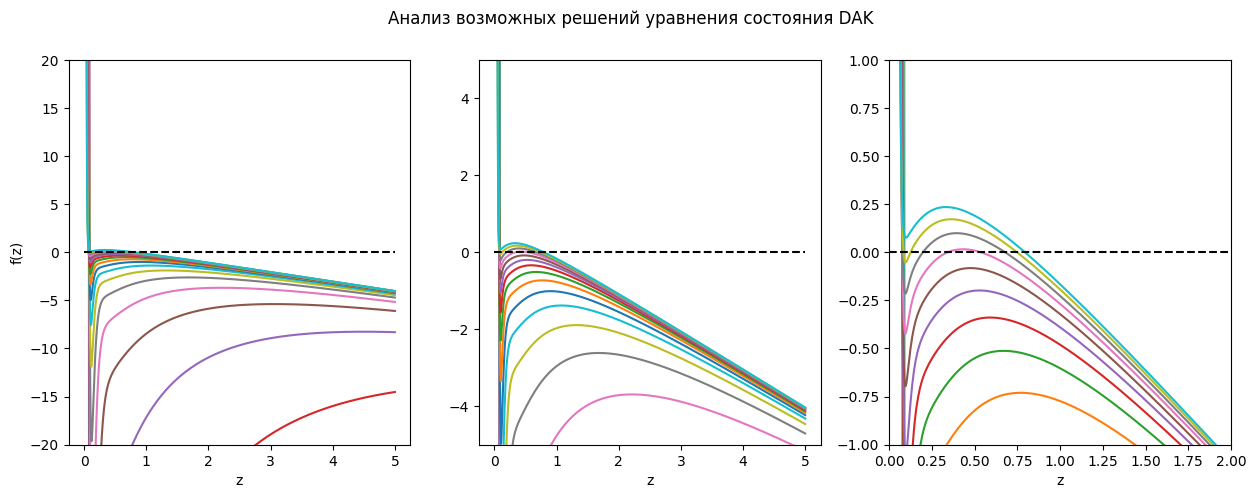

In [14]:
# построим графики функций на основе уравнения состояния из модели DAK

# потом для диапазона, где все должно хорошо работать, но может отличаться от реальности
z = np.linspace(0.01, 5, 1000)
ppr_list = np.linspace(0.5, 1, 1)  
tpr_list = np.linspace(0.1, 1, 20)

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('Анализ возможных решений уравнения состояния DAK')
for ppr in ppr_list:
    for tpr in tpr_list:
        ax[0].plot(z,f(z,ppr,tpr))
        ax[1].plot(z,f(z,ppr,tpr))
        ax[2].plot(z,f(z,ppr,tpr))


ax[0].plot([0,5],[0,0], color='black', linestyle='dashed')
ax[1].plot([0,5],[0,0], color='black', linestyle='dashed')
ax[2].plot([0,5],[0,0], color='black', linestyle='dashed')

ax[0].set_ylim(-20,20)
ax[1].set_ylim(-5,5)
ax[2].set_ylim(-1, 1)
ax[2].set_xlim(0, 2)

ax[0].set(xlabel='z', ylabel='f(z)')
ax[1].set(xlabel='z')
ax[2].set(xlabel='z')
plt.show()

При низких значениях температуры решение для уравнения состояния может оказаться несколько решений. Это соответствует зоне существования двух фаз одновременно. Около критической точки и по давлению и по температуре функция может оказаться близка к нулю на отрезке. Такое поведение функции усложняет расчет. Стандартные методы поиска решений (метод Ньютона, метод деления отрезка) могут оказаться неустойчивыми.

 method Cubic roots [0.23732533 0.27866875 0.36843363 0.46946011 0.56857987]
 method Akima roots [0.45344351]
 method Pchip roots [0.41678352]


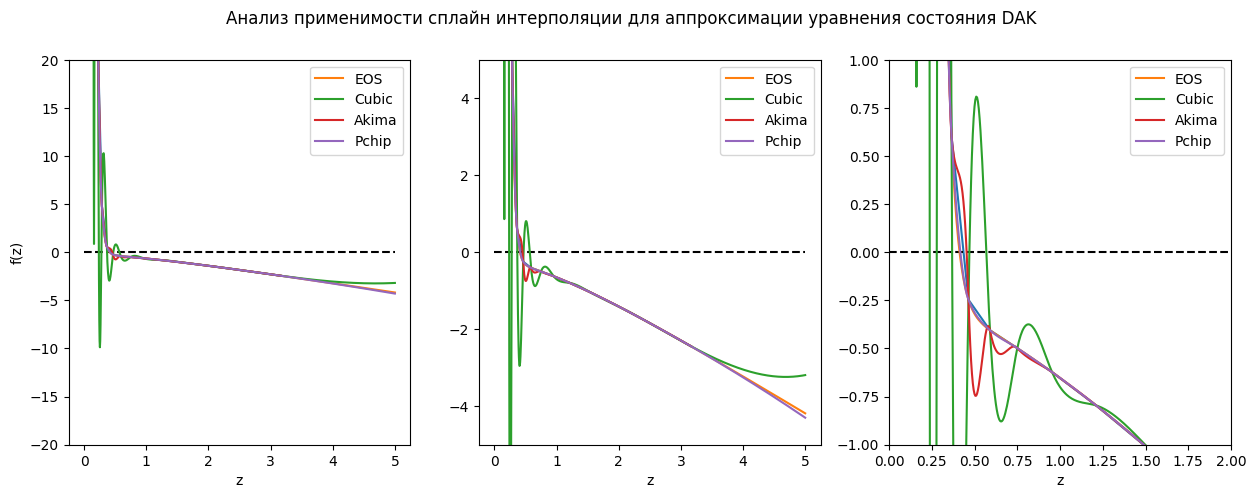

In [15]:
# построим графики уравнения состояния, чтобы оценить адекватность интерполяции стплайнами

z = np.logspace(-2, 0.5, 25)
#z = np.linspace(0.01, 5, 20)  не вариант - совсем плохо около нуля

ppr = 2.8
tpr = 1

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('Анализ применимости сплайн интерполяции для аппроксимации уравнения состояния DAK')

for i in [0,1,2]:
    ax[i].plot(z,f(z,ppr,tpr))
    ax[i].plot([0,5],[0,0], color='black', linestyle='dashed')
spl = {}
spl['Cubic'] = CubicSpline(z,f(z,ppr,tpr))
spl['Akima'] = Akima1DInterpolator(z,f(z,ppr,tpr))
spl['Pchip'] = PchipInterpolator(z,f(z,ppr,tpr))

for k in spl:
    print(f' method {k} roots {spl[k].roots(extrapolate=False)}')

z = np.linspace(0.01, 5, 1000)

for i in [0,1,2]:
    ax[i].plot(z,f(z,ppr,tpr), label='EOS')
    for k in spl:
        ax[i].plot(z,spl[k](z), label=k)
    ax[i].legend()

ax[0].set_ylim(-20,20)
ax[1].set_ylim(-5,5)
ax[2].set_ylim(-1, 1)
ax[2].set_xlim(0, 2)
ax[0].set(xlabel='z', ylabel='f(z)')
ax[1].set(xlabel='z')
ax[2].set(xlabel='z')
plt.show()

In [16]:
for k in spl:
    print(k)
    %timeit spl[k].roots(extrapolate=False)


Cubic
181 μs ± 7.52 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Akima
166 μs ± 708 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Pchip
154 μs ± 602 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
def unf_zfactor_DAK_ppr_(ppr:float, tpr:float, safe:bool=True)->float:
    """
        Correlation for z-factor

    :param ppr: pseudoreduced pressure
    :param tpr: pseudoreduced temperature
    :param safe: если True то расчет ограничивается только tpr>1.05, что гарантирует корректность
    :return: z-factor

    range of applicability is (0.2<=ppr<30 and 1.0<tpr<=3.0) and also ppr < 1.0 for 0.7 < tpr < 1.0

    ref 1 Dranchuk, P.M. and Abou-Kassem, J.H. “Calculation of Z Factors for Natural
    Gases Using Equations of State.” Journal of Canadian Petroleum Technology. (July–September 1975) 34–36.
    """
    if safe and tpr <= 1.05:
        tpr=1.05
        #TODO надо бы тут выдать в лог какое то предупреждение - может корежить результаты
    def f(z, ppr, tpr):
        ropr = 0.27 * (ppr / (z * tpr)) 
        ropr2 = ropr * ropr
        func = -z + 1 + \
                (0.3265 - 1.0700 / tpr - 0.5339 / tpr**3 + 0.01569 / tpr**4 - 0.05165 / tpr**5) * ropr +\
                (0.5475 - 0.7361 / tpr + 0.1844 / tpr**2) * ropr2 - \
                0.1056 * (-0.7361 / tpr + 0.1844 / tpr**2) * ropr**5 + \
                0.6134 * (1 + 0.7210 * ropr2) * (ropr2 / tpr ** 3) * np.exp(-0.7210 * ropr2)
        return func
    if safe or tpr >= 1.05:
        solution = opt.root_scalar(f, (ppr, tpr),  method='bisect', bracket=(0.1, 5))
        solution = solution.root
    else:
        if tpr < 1.05:
            # может быть несколько решений - применяем поиск решения по сплайн аппроксимации
            z = np.logspace(-2, 0.5, 30) # 30 точек с небольшим запасом для интерполяции
            spl = PchipInterpolator(z, f(z, ppr, tpr))
            solutions = spl.roots(extrapolate=False)
            solution = max(solutions)
    # по идее расчет в безопасном диапазоне по температуре должен считать быстрее, так как требует меньше вызовов f
    # но по факту опасный расчет с определение корней по интерполированному сплайну тоже быстр, хотя требует 25 вызовов f
    # скорее всего из за того, что все вызовы делаются в векторной форме.
    # возможно далее для унификации можно отказаться от расчета
    return solution

In [18]:
unf_zfactor_DAK_ppr_(2.7, 1.03)

0.41072073690436356

In [19]:
unf_zfactor_DAK_ppr = np.vectorize(unf_zfactor_DAK_ppr_)

unf_zfactor_Kareem =  np.vectorize(pvtg.unf_zfactor_Kareem)

unf_zfactor_BrillBeggs = np.vectorize(pvtg.unf_zfactor_BrillBeggs)

Сравнение экспериментального графика Стендинга-Каци и уравнения Дранчука и Абу-Кассема

In [20]:
unf_zfactor_DAK_ppr(np.array([2,3]), np.array([2,3]))

array([0.94593435, 1.0113074 ])

In [21]:
unf_zfactor_Kareem(np.array([2,3]), np.array([1,3]))

array([0.34061887, 1.01156766])

d:\unifloc\neftpy\notebooks\..\neftpy\upvt_gas.py:241: RuntimeWarning: invalid value encountered in scalar divide
  z = DPpr * (1 + y + y ** 2 - y ** 3) / (DPpr + EE * y ** 2 - FF * y ** GG) / ((1 - y) ** 3)


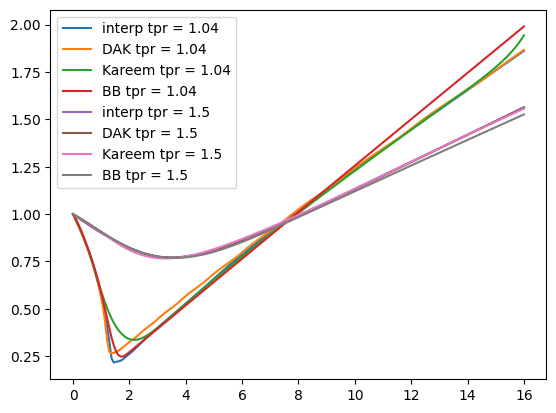

In [22]:
tpr = 1.04
ppr = np.linspace(0, 16, 200)

z1 = interp_SK((ppr, tpr))
z2 = unf_zfactor_DAK_ppr(ppr, tpr, safe=False)
z3 = unf_zfactor_Kareem(ppr, tpr)
z4 = unf_zfactor_BrillBeggs(ppr, tpr)

plt.plot(ppr, z1, label=f'interp tpr = {tpr}')
plt.plot(ppr, z2, label=f'DAK tpr = {tpr}')
plt.plot(ppr, z3, label=f'Kareem tpr = {tpr}')
plt.plot(ppr, z4, label=f'BB tpr = {tpr}')

tpr = 1.5

z1 = interp_SK((ppr, tpr))
z2 = unf_zfactor_DAK_ppr(ppr, tpr)
z3 = unf_zfactor_Kareem(ppr, tpr)
z4 = unf_zfactor_BrillBeggs(ppr, tpr)

plt.plot(ppr, z1, label='interp tpr = 1.5')
plt.plot(ppr, z2, label='DAK tpr = 1.5')
plt.plot(ppr, z3, label='Kareem tpr = 1.5')
plt.plot(ppr, z4, label='BB tpr = 1.5')

plt.legend()
plt.show()

In [23]:
%timeit z1 = interp_SK((ppr, tpr))
%timeit z2 = unf_zfactor_DAK_ppr(ppr, tpr)
%timeit z3 = unf_zfactor_Kareem(ppr, tpr)
%timeit z4 = unf_zfactor_BrillBeggs(ppr, tpr)

186 μs ± 1.99 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
117 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.74 ms ± 221 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.79 ms ± 230 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


вывод - интерполяционный расчет заметно выигрывает по скорости у других методов
- а еще может легко выдать производную, которая тоже может пригодиться